# Water Observation from Space (WOFS)

Reference: https://www.sciencedirect.com/science/article/pii/S0034425715301929

In [1]:
# Display the matplotlib plots in the notebook
%matplotlib inline

import xarray as xr
import numpy as np
import datacube

# Wofs imports
import gc
import collections

# Supress the warning in a notebook so that they 
# are not displayed when running cells.
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore')

import compounds
import utils

## Datacube Query

**Ingested Area:**
    - Latitude: 4,5
    - Longitude: -70, -69
    - Time: 2018/08/03 - 2018/12/25

In [2]:
dc = datacube.Datacube(app="Query")

xarr = dc.load(
    product="LS8_OLI_LASRC",
    latitude=(4.3388,4.4118),
    longitude=(-69.9390,-69.8659), 
    # Time format YYYY-MM-DD
    time=("2018-01-01","2018-12-31"), 
    measurements=['blue','green','red','nir','swir1','swir2','pixel_qa']
)

xarr

<xarray.Dataset>
Dimensions:    (latitude: 270, longitude: 272, time: 3)
Coordinates:
  * time       (time) datetime64[ns] 2018-11-23T14:54:08 ... 2018-12-25T14:54:05
  * latitude   (latitude) float64 4.412 4.412 4.411 4.411 ... 4.339 4.339 4.339
  * longitude  (longitude) float64 -69.94 -69.94 -69.94 ... -69.87 -69.87 -69.87
Data variables:
    blue       (time, latitude, longitude) int16 198 319 352 ... 1350 1453 1626
    green      (time, latitude, longitude) int16 444 559 606 ... 1554 1649 1875
    red        (time, latitude, longitude) int16 257 472 599 ... 1417 1537 1712
    nir        (time, latitude, longitude) int16 3392 2962 2557 ... 3360 3520
    swir1      (time, latitude, longitude) int16 1649 2274 2618 ... 2327 2476
    swir2      (time, latitude, longitude) int16 630 1016 1258 ... 1741 1958
    pixel_qa   (time, latitude, longitude) int32 322 322 322 322 ... 480 480 480
Attributes:
    crs:      EPSG:4326

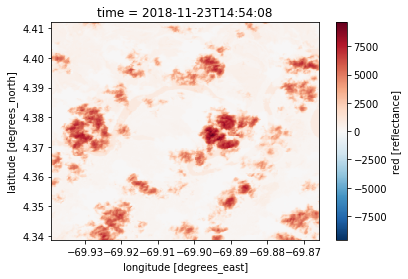

In [3]:
xarr.red[0].plot()
#xarr.red[1].plot()
#xarr.red[2].plot()

## Wofs Classification

Reference: https://github.com/GeoscienceAustralia/wofs

In [4]:
def wofs_classify(dataset_in, clean_mask=None, no_data=-9999, enforce_float64=False):
    """
    Description:
      Performs WOfS algorithm on given dataset. If no clean mask is given, the 'cf_mask'
      variable must be included in the input dataset, as it will be used to create a 
      clean mask
    Assumption:
      - The WOfS algorithm is defined for Landsat 5/Landsat 7 
    References:
      - Mueller, et al. (2015) "Water observations from space: Mapping surface water from 
        25 years of Landsat imagery across Australia." Remote Sensing of Environment.
      - https://github.com/GeoscienceAustralia/eo-tools/blob/stable/eotools/water_classifier.py
    -----
    Inputs:
      dataset_in (xarray.Dataset) - dataset retrieved from the Data Cube; should contain
        coordinates: time, latitude, longitude
        variables: blue, green, red, nir, swir1, swir2
        If user does not provide a clean_mask, dataset_in must also include the cf_mask
        variable
    Optional Inputs:
      clean_mask (nd numpy array with dtype boolean) - true for values user considers clean;
        if user does not provide a clean mask, one will be created using cfmask
      no_data (int/float) - no data pixel value; default: -9999
      enforce_float64 (boolean) - flag to indicate whether or not to enforce float64 calculations;
        will use float32 if false
    Output:
      dataset_out (xarray.DataArray) - wofs water classification results: 0 - not water; 1 - water
    """
    
    def _band_ratio(a, b):
        """
        Calculates a normalized ratio index
        """
        return (a - b) / (a + b)
        
    def _run_regression(band1, band2, band3, band4, band5, band7):
        """
        Regression analysis based on Australia's training data
        TODO: Return type
        """
        
        # Compute normalized ratio indices
        ndi_52 = _band_ratio(band5, band2)
        ndi_43 = _band_ratio(band4, band3)
        ndi_72 = _band_ratio(band7, band2)
        
        #classified = np.ones(shape, dtype='uint8')
        
        classified = np.full(shape, no_data)
      
        # Start with the tree's left branch, finishing nodes as needed
        
        # Left branch
        r1 = ndi_52 <= -0.01

        r2 = band1 <= 2083.5
        classified[r1 & ~r2] = 0 #Node 3

        r3 = band7 <= 323.5
        _tmp = r1 & r2
        _tmp2 = _tmp & r3
        _tmp &= ~r3

        r4 = ndi_43 <= 0.61
        classified[_tmp2 & r4] = 1 #Node 6
        classified[_tmp2 & ~r4] = 0 #Node 7

        r5 = band1 <= 1400.5
        _tmp2 = _tmp & ~r5

        r6 = ndi_43 <= -0.01
        classified[_tmp2 & r6] = 1 #Node 10
        classified[_tmp2 & ~r6] = 0 #Node 11

        _tmp &= r5

        r7 = ndi_72 <= -0.23
        _tmp2 = _tmp & ~r7

        r8 = band1 <= 379
        classified[_tmp2 & r8] = 1 #Node 14
        classified[_tmp2 & ~r8] = 0 #Node 15

        _tmp &= r7

        r9 = ndi_43 <= 0.22
        classified[_tmp & r9] = 1 #Node 17
        _tmp &= ~r9

        r10 = band1 <= 473
        classified[_tmp & r10] = 1 #Node 19
        classified[_tmp & ~r10] = 0 #Node 20

        # Left branch complete; cleanup
        del r2, r3, r4, r5, r6, r7, r8, r9, r10
        gc.collect()
        
        # Right branch of regression tree
        r1 = ~r1

        r11 = ndi_52 <= 0.23
        _tmp = r1 & r11

        r12 = band1 <= 334.5
        _tmp2 = _tmp & ~r12
        classified[_tmp2] = 0 #Node 23

        _tmp &= r12

        r13 = ndi_43 <= 0.54
        _tmp2 = _tmp & ~r13
        classified[_tmp2] = 0 #Node 25

        _tmp &= r13

        r14 = ndi_52 <= 0.12
        _tmp2 = _tmp & r14
        classified[_tmp2] = 1 #Node 27

        _tmp &= ~r14

        r15 = band3 <= 364.5
        _tmp2 = _tmp & r15

        r16 = band1 <= 129.5
        classified[_tmp2 & r16] = 1 #Node 31
        classified[_tmp2 & ~r16] = 0 #Node 32

        _tmp &= ~r15

        r17 = band1 <= 300.5
        _tmp2 = _tmp & ~r17
        _tmp &= r17
        classified[_tmp] = 1 #Node 33
        classified[_tmp2] = 0 #Node 34

        _tmp = r1 & ~r11

        r18 = ndi_52 <= 0.34
        classified[_tmp & ~r18] = 0 #Node 36
        _tmp &= r18

        r19 = band1 <= 249.5
        classified[_tmp & ~r19] = 0 #Node 38
        _tmp &= r19

        r20 = ndi_43 <= 0.45
        classified[_tmp & ~r20] = 0 #Node 40
        _tmp &= r20

        r21 = band3 <= 364.5
        classified[_tmp & ~r21] = 0 #Node 42
        _tmp &= r21

        r22 = band1 <= 129.5
        classified[_tmp & r22] = 1 #Node 44
        classified[_tmp & ~r22] = 0 #Node 45

        # Completed regression tree
        
        return classified
    
    # Extract dataset bands needed for calculations
    blue = dataset_in.blue
    green = dataset_in.green
    red = dataset_in.red
    nir = dataset_in.nir
    swir1 = dataset_in.swir1
    swir2 = dataset_in.swir2
    
    # Create a clean mask from cfmask if the user does not provide one
    if not clean_mask:
        cfmask = dataset_in.pixel_qa
        clean_mask = create_cfmask_clean_mask(cfmask)
    
    # Enforce float calculations - float64 if user specified, otherwise float32 will do
    dtype = blue.values.dtype # This assumes all dataset bands will have
                              # the same dtype (should be a reasonable
                              # assumption)

    if enforce_float64:
        if dtype != 'float64':
            blue.values = blue.values.astype('float64')
            green.values = green.values.astype('float64')
            red.values = red.values.astype('float64')
            nir.values = nir.values.astype('float64')
            swir1.values = swir1.values.astype('float64')
            swir2.values = swir2.values.astype('float64')
    else:
        if dtype == 'float64':
            pass
        elif dtype != 'float32':
            blue.values = blue.values.astype('float32')
            green.values = green.values.astype('float32')
            red.values = red.values.astype('float32')
            nir.values = nir.values.astype('float32')
            swir1.values = swir1.values.astype('float32')
            swir2.values = swir2.values.astype('float32')
    
    shape = blue.values.shape
    classified = _run_regression(blue.values, green.values, red.values, 
                                 nir.values, swir1.values, swir2.values)

    classified_clean = np.full(classified.shape, no_data)
    classified_clean[clean_mask] = classified[clean_mask] # Contains data for clear pixels
    
    # Create xarray of data
    time = dataset_in.time
    if hasattr(dataset_in,'latitude'):
        latitude = dataset_in.latitude 
        longitude = dataset_in.longitude 
    
        data_array = xr.DataArray(classified_clean,
                              coords=[time, latitude, longitude],
                              dims=['time', 'latitude', 'longitude'])
    
        dataset_out = xr.Dataset({'wofs': data_array},
                             coords={'time': time,
                                     'latitude': latitude,
                                     'longitude': longitude})
    else:
        y = dataset_in.y 
        x = dataset_in.x
        data_array = xr.DataArray(classified_clean,
                              coords=[time, y, x],
                              dims=['time', 'y', 'x'])
    
        dataset_out = xr.Dataset({'wofs': data_array},
                             coords={'time': time,
                                     'y': y,
                                     'x': x})
                                     
    return dataset_out

def create_cfmask_clean_mask(cfmask):
    """
    Description:
      Create a clean mask for clear land/water pixels,
      i.e. mask out shadow, snow, cloud, and no data
    -----
    Input:
      cfmask (xarray) - cf_mask from the ledaps products
    Output:
      clean_mask (boolean numpy array) - clear land/water mask
    """

    #########################
    # cfmask values:        #
    #   0 - clear           #
    #   1 - water           #
    #   2 - cloud shadow    #
    #   3 - snow            #
    #   4 - cloud           #
    #   255 - fill          #
    #########################

    clean_mask = np.reshape(np.in1d(cfmask.values.reshape(-1), [2, 3, 4, 255], invert=True),
                            cfmask.values.shape)
    return clean_mask

def get_spatial_ref(crs):
    """
    Description:
      Get the spatial reference of a given crs
    -----
    Input:
      crs (datacube.model.CRS) - Example: CRS('EPSG:4326')
    Output:
      ref (str) - spatial reference of given crs
    """

    crs_str = str(crs)
    epsg_code = int(crs_str.split(':')[1])
    ref = osr.SpatialReference()
    ref.ImportFromEPSG(epsg_code)
    return str(ref)

def perform_timeseries_analysis(dataset_in, no_data=-9999):
    """
    Description:

    -----
    Input:
      dataset_in (xarray.DataSet) - dataset with one variable to perform timeseries on
    Output:
      dataset_out (xarray.DataSet) - dataset containing 
        variables: normalized_data, total_data, total_clean
    """
    
    data_vars = dataset_in.data_vars
    #key = data_vars.keys()[0]
    key = "wofs"
    
    data = data_vars[key]

    #shape = data.shape[1:]

    data_dup = data.copy(deep=True)
    data_dup.values = data_dup.values.astype('float')
    data_dup.values[data.values == no_data] = 0

    processed_data_sum = data_dup.sum('time')
    # Masking no data values then converting boolean to int for easy summation
    clean_data_raw = np.reshape(np.in1d(data.values.reshape(-1), [no_data], invert=True),
                                        data.values.shape).astype(int)
    # Create xarray of data
    time = data.time

    if hasattr(data, "latitude"):
        latitude = data.latitude
        longitude = data.longitude
        clean_data = xr.DataArray(clean_data_raw,
                              coords=[time, latitude, longitude],
                              dims=['time', 'latitude', 'longitude'])
    else:
        y = data.y
        x = data.x
        clean_data = xr.DataArray(clean_data_raw,
                              coords=[time, y, x],
                              dims=['time', 'y', 'x'])

    


    

    clean_data_sum = clean_data.sum('time')

    processed_data_normalized = processed_data_sum/clean_data_sum
    if hasattr(data, "latitude"):
        dataset_out = xr.Dataset(collections.OrderedDict([('normalized_data', (['latitude', 'longitude'], processed_data_normalized)),
                                                      ('total_data', (['latitude', 'longitude'], processed_data_sum)),
                                                      ('total_clean', (['latitude', 'longitude'], clean_data_sum))]),
                             coords={'latitude': latitude,
                                     'longitude': longitude})
    else:
        dataset_out = xr.Dataset(collections.OrderedDict([('normalized_data', (['y', 'x'], processed_data_normalized)),
                                                      ('total_data', (['y', 'x'], processed_data_sum)),
                                                      ('total_clean', (['y', 'x'], clean_data_sum))]),
                             coords={'y': y,
                                     'x': x})
    return dataset_out

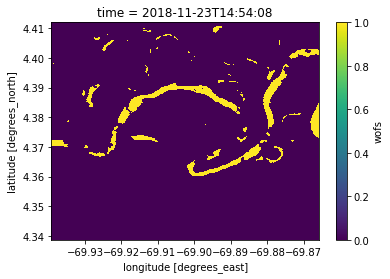

In [5]:
xarr0 = xarr.copy(deep=True)
output = wofs_classify(xarr0)

output.wofs[0].plot()

## Time Series

In [6]:
time_series = perform_timeseries_analysis(output)
#output.attrs["crs"]=xarr0.crs
#outputs={}

output_normalized_data = utils.get_data_set(time_series.normalized_data,var_name='normalized_data',xarr0=xarr0)
output_total_clean = utils.get_data_set(time_series.total_clean,var_name='total_clean',xarr0=xarr0)
output_total_data = utils.get_data_set(time_series.total_data,var_name='total_data',xarr0=xarr0)

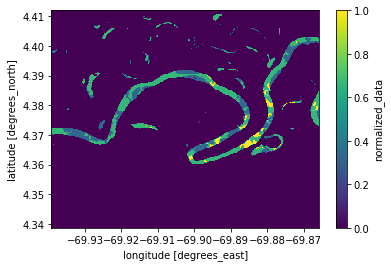

In [7]:
output_normalized_data.normalized_data.plot()